### Unified Telemetry-FHR Hello World

This is a very a brief introduction to Spark and Telemetry in Python. You should have a look at the [tutorial](https://gist.github.com/vitillo/25a20b7c8685c0c82422) in Scala and the associated [talk](http://www.slideshare.net/RobertoAgostinoVitil/spark-meets-telemetry) if you are interested to learn more about Spark.

In [2]:
import ujson as json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.plotly as py
from plotly.graph_objs import *

from moztelemetry import get_pings, get_pings_properties, get_one_ping_per_client, get_clients_history, get_records

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### Basics

The goal of this example is to plot the startup distribution for each OS. Let's see how many parallel workers we have at our disposal:

In [3]:
sc.defaultParallelism

16

Let's fetch 10% of Telemetry submissions for a given build-id...

In [4]:
pings = get_pings(sc, app="Firefox", channel="nightly", build_id=("20150520000000", "20150520999999"), fraction=0.1)

... and extract only the attributes we need from the Telemetry submissions:

In [5]:
subset = get_pings_properties(pings, ["clientId",
                                      "environment/system/os/name",
                                      "payload/simpleMeasurements/firstPaint"])

Let's filter out submissions with an invalid startup time:

In [6]:
subset = subset.filter(lambda p: p.get("payload/simpleMeasurements/firstPaint", -1) >= 0)

To prevent pseudoreplication, let's consider only a single submission for each client. As this step requires a distributed shuffle, it should always be run only after extracting the attributes of interest with *get_pings_properties*.

In [7]:
subset = get_one_ping_per_client(subset)

Caching is fundamental as it allows for an iterative, real-time development workflow:

In [8]:
cached = subset.cache()

How many pings are we looking at?

In [9]:
cached.count()

1159

Let's group the startup timings by OS:

In [10]:
grouped = cached.map(lambda p: (p["environment/system/os/name"], p["payload/simpleMeasurements/firstPaint"])).groupByKey().collectAsMap()

And finally plot the data:

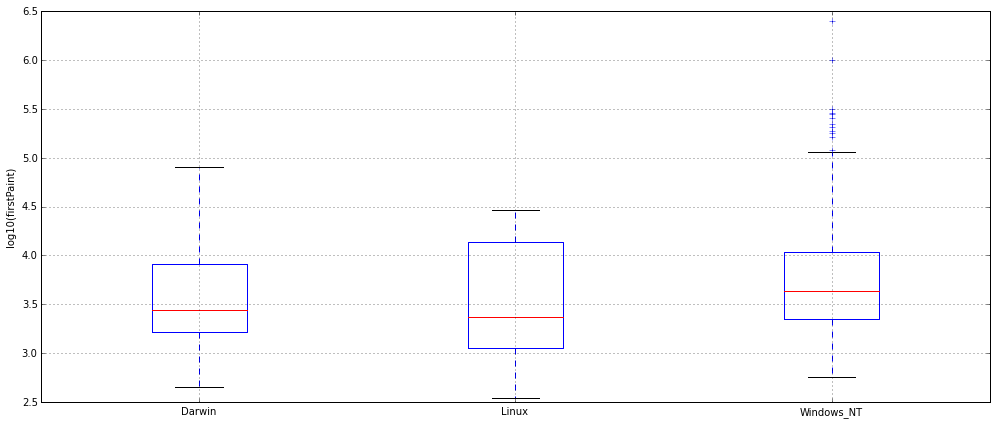

In [11]:
frame = pd.DataFrame({x: np.log10(pd.Series(list(y))) for x, y in grouped.items()})
plt.figure(figsize=(17, 7))
frame.boxplot(return_type="axes")
plt.ylabel("log10(firstPaint)")
plt.show()

You can also create interactive plots with [plotly](https://plot.ly/):

In [12]:
fig = plt.figure(figsize=(18, 7))
frame["Windows_NT"].plot(kind="hist", bins=50)
plt.title("startup distribution for Windows")
plt.ylabel("count")
plt.xlabel("log10(firstPaint)")
py.iplot_mpl(fig, strip_style=True)

###Histograms

Let's fetch some pings first:

In [13]:
pings = get_pings(sc, app="Firefox", channel="nightly", submission_date="20150426", fraction=0.1, schema="v4")

Let's extract a histogram from the submissions:

In [14]:
histograms = get_pings_properties(pings, "payload/histograms/GC_MARK_MS", with_processes=True)

The API returns three distinct histograms for each submission:
- a histogram for the parent process (*GC_MARK_MS_parent*)
- an aggregated histogram for the child processes (*GC_MARK_MS_children*)
- the aggregate of the parent and child histograms (*GC_MARK*)

Let's aggregate the histogram over all submissions and plot it:

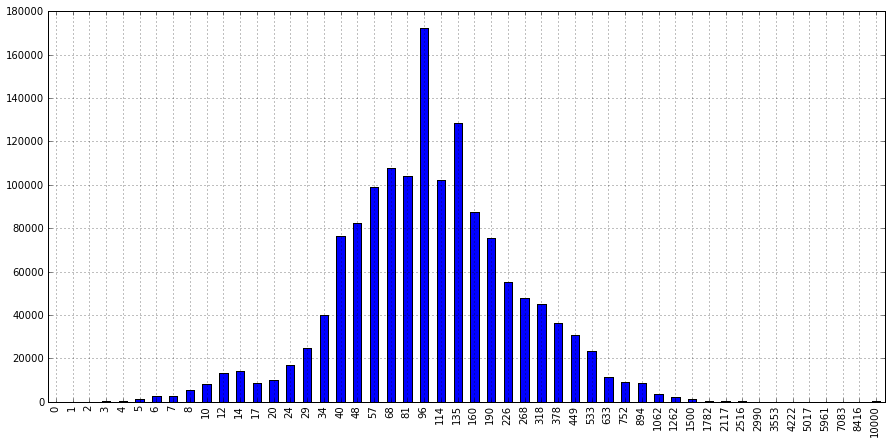

In [15]:
def aggregate_arrays(xs, ys):
    if xs is None:
        return ys
    
    if ys is None:
        return xs
    
    return xs + ys
    
aggregate = histograms.map(lambda p: p["payload/histograms/GC_MARK_MS"]).reduce(aggregate_arrays)
aggregate.plot(kind="bar", figsize=(15, 7))

Keyed histograms follow a similar pattern. To extract a keyed histogram for which we know the key/label we are interested in:

In [16]:
histograms = get_pings_properties(pings, "payload/keyedHistograms/SUBPROCESS_ABNORMAL_ABORT/plugin", with_processes=True)

Let's list all keys/labels for a keyed histogram:

In [17]:
keys = pings.flatMap(lambda p: p["payload"].get("keyedHistograms", {}).get("MISBEHAVING_ADDONS_JANK_LEVEL", {}).keys())
keys = keys.distinct().collect()

In [18]:
keys[:5]

[u'jid1-MnnxcxisBPnSXQ@jetpack',
 u'{19503e42-ca3c-4c27-b1e2-9cdb2170ee34}',
 u'jid0-3GUEt1r69sQNSrca5p8kx9Ezc3U@jetpack',
 u'{7c231677-e4fb-44ac-80a5-c87fcb7c2be9}',
 u'{d40f5e7b-d2cf-4856-b441-cc613eeffbe3}']

Let's retrieve the histograms for a set of labels:

In [19]:
properties = map(lambda k: "payload/keyedHistograms/{}/{}".format("MISBEHAVING_ADDONS_JANK_LEVEL", k), keys[:5])

In [20]:
histograms = get_pings_properties(pings, properties, with_processes=True)

### Client API

Let's retrieve the fragments for a fraction of the clients on all channel. Note that only 1% of all clients are available and the fraction argument passed to *get_clients_history* is applied on top of that. 

The function returns a RDD of (client-id, ping), hash-partitioned on the client-id. What this means is that submissions from the same client are processed on the same machine and thus an expensive shuffle isn't needed when computing aggregates with e.g. *groupByKey* or *reduceByKey*.

In [21]:
pings = get_clients_history(sc, fraction = 0.1)

How many clients do we have?

In [22]:
pings.keys().distinct().count()

17439

How does the distribution of the number of fragments per client look like for clients that have been recently been on nightly?

In [23]:
def filter_main_nightly(x):
    client_id, ping = x
    
    if ping[u'type'] != u'main':
        return False
    if ping[u'environment'][u'settings'][u'update'][u'channel'] != 'nightly':
        return False
    if ping[u'environment'][u'build'][u'buildId'] <= '20150610':
        return False
    
    return True

In [24]:
matching_clients = pings.filter(filter_main_nightly).keys().distinct().collect()
matching_pings = pings.filter(lambda x: x[0] in matching_clients).countByKey()

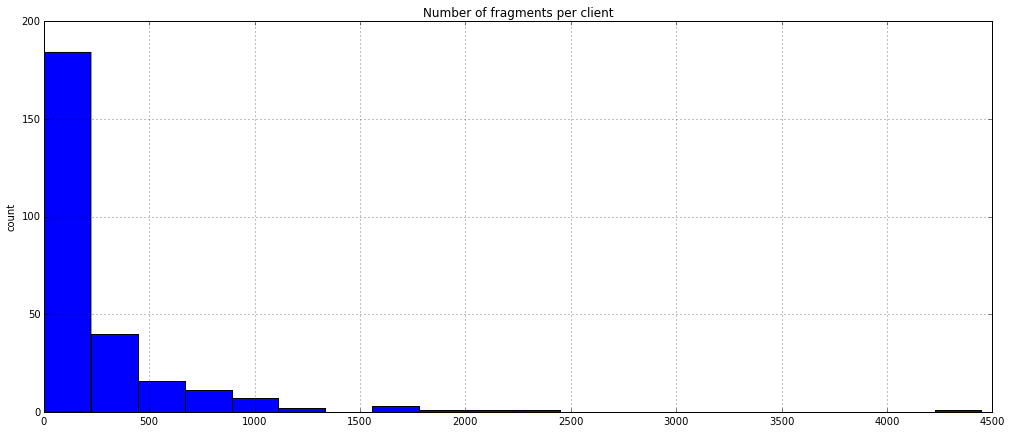

In [25]:
pd.Series(matching_pings).plot(kind="hist", bins=20, figsize=(17, 7))
plt.title("Number of fragments per client")
plt.ylabel("count")

#Derived Streams

Sometimes we do not want or need the full set of v4 data. For such cases, we can create a derived data stream containing exactly the fields and records we are interested in. When we end up with a data set that is generally useful, we can register it as a Derived Stream, making it consumable within Spark.

One such stream is the "Executive Summary" stream. We can access derived streams using the `get_records` function.

Let's look at an example of using a derived stream.

In [26]:
derived = get_records(sc, "telemetry-executive-summary", submissionDate="20150901", fraction=0.1)

We'll check the distribution of the `reason` field in `main` pings, so let's filter those first.

In [27]:
main_pings = derived.filter(lambda x: x["meta"]["docType"] == "main" and x["meta"]["reason"] != '')

In [28]:
reasons = main_pings.map(lambda x: (x["meta"]["reason"], 1)).countByKey()

And plot the resulting counts:

In [29]:
xd = []
yd = []
for k in sorted(reasons.keys()):
    xd.append(k)
    yd.append(reasons[k])

data = Data([Bar(x=xd, y=yd)])
py.iplot(data, filename='reasons')
    